C:\Users\Furkan\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Furkan\anaconda3\envs\pytorch\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Train classes: 64 --> ['train', 'skyscraper', 'turtle', 'raccoon', 'spider']...
Val classes:   16 --> ['otter', 'motorcycle', 'television', 'lamp', 'crocodile']...
Test classes:  20 --> ['baby', 'bed', 'bicycle', 'chimpanzee', 'fox']...
# Train Samples: 38400
# Val   Samples: 9600
# Test  Samples: 12000
Train - Minimum images in any class = 600
Val - Minimum images in any class = 600
Test - Minimum images in any class = 600
Total unique classes: 100
Sample label mapping: {'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'bear': 3, 'beaver': 4}
No missing files detected.
Train classes in dict: 64
Val   classes in dict: 16
Test  classes in dict: 20

Visualizing some Train Samples:


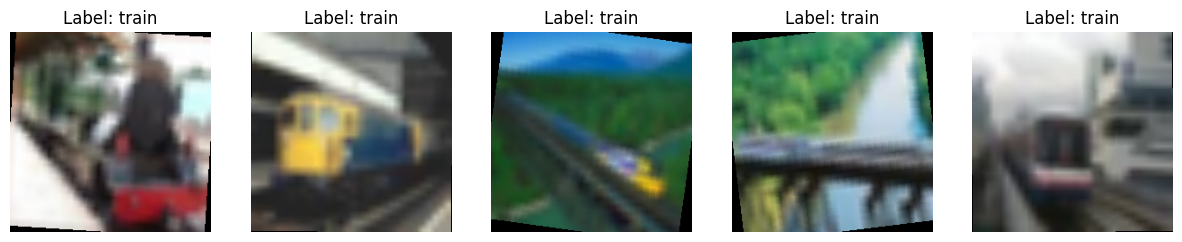


Visualizing some Val Samples:


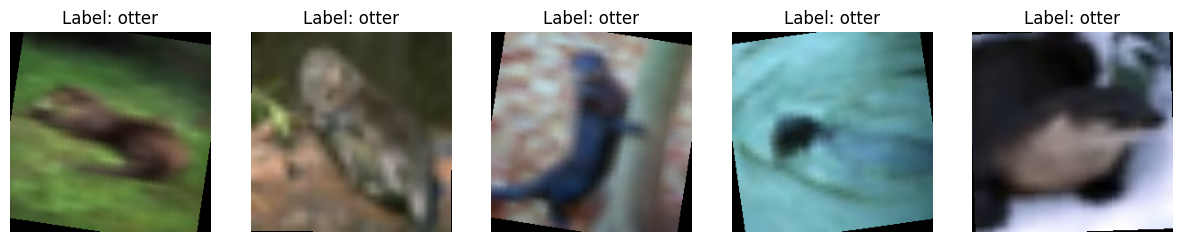


Starting Training...
Episode 1/1000, Loss: 0.276724, Accuracy: 92.00%, Time/Episode: 19.54s, Elapsed: 19.54s, Remaining: ~19521.31s
[Validation] Episode 10, Accuracy: 92.93%
[Validation] Episode 20, Accuracy: 91.41%
[Validation] Episode 30, Accuracy: 90.40%
[Validation] Episode 40, Accuracy: 93.04%
[Validation] Episode 50, Accuracy: 91.92%
Episode 51/1000, Loss: 0.043139, Accuracy: 98.67%, Time/Episode: 15.21s, Elapsed: 929.81s, Remaining: ~17301.82s
[Validation] Episode 60, Accuracy: 92.19%
[Validation] Episode 70, Accuracy: 91.63%
[Validation] Episode 80, Accuracy: 92.24%
[Validation] Episode 90, Accuracy: 93.07%
[Validation] Episode 100, Accuracy: 92.48%
Episode 101/1000, Loss: 0.101110, Accuracy: 94.67%, Time/Episode: 15.93s, Elapsed: 1834.68s, Remaining: ~16330.43s
[Validation] Episode 110, Accuracy: 93.12%
[Validation] Episode 120, Accuracy: 91.89%
[Validation] Episode 130, Accuracy: 91.79%
[Validation] Episode 140, Accuracy: 90.64%
[Validation] Episode 150, Accuracy: 93.25%
Epi

Evaluating: 100%|██████████| 100/100 [04:04<00:00,  2.44s/it]


Per-episode Accuracies:
 Episode  1: 94.67%
 Episode  2: 97.33%
 Episode  3: 97.33%
 Episode  4: 98.67%
 Episode  5: 97.33%
 Episode  6: 96.00%
 Episode  7: 100.00%
 Episode  8: 90.67%
 Episode  9: 98.67%
 Episode 10: 96.00%
 Episode 11: 93.33%
 Episode 12: 90.67%
 Episode 13: 90.67%
 Episode 14: 97.33%
 Episode 15: 98.67%
 Episode 16: 90.67%
 Episode 17: 90.67%
 Episode 18: 97.33%
 Episode 19: 100.00%
 Episode 20: 97.33%
 Episode 21: 100.00%
 Episode 22: 100.00%
 Episode 23: 96.00%
 Episode 24: 100.00%
 Episode 25: 96.00%
 Episode 26: 100.00%
 Episode 27: 92.00%
 Episode 28: 98.67%
 Episode 29: 96.00%
 Episode 30: 85.33%
 Episode 31: 78.67%
 Episode 32: 97.33%
 Episode 33: 93.33%
 Episode 34: 88.00%
 Episode 35: 94.67%
 Episode 36: 96.00%
 Episode 37: 85.33%
 Episode 38: 96.00%
 Episode 39: 100.00%
 Episode 40: 94.67%
 Episode 41: 94.67%
 Episode 42: 100.00%
 Episode 43: 96.00%
 Episode 44: 94.67%
 Episode 45: 88.00%
 Episode 46: 94.67%
 Episode 47: 97.33%
 Episode 48: 97.33%
 Episod

In [1]:
import os
import time
import torch
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from collections import defaultdict

from torch.utils.data import Dataset
import torchvision.transforms as transforms

import timm
from timm.models.vision_transformer import VisionTransformer
from timm.models.layers import to_2tuple

# 1. Enable Synchronous CUDA Error Reporting
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# 2. Define Constants
DATASET_PATH = "C:/Users/Furkan/Desktop/cifar/cifar100/data"
SPLITS_PATH = "C:/Users/Furkan/Desktop/cifar/cifar100/splits"

IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPISODES = 1000    # Changed to 1000
SHOTS = 5
QUERY = 15
NUM_CLASSES_PER_EPISODE = 5

# We'll still evaluate periodically but no early stopping
EVAL_FREQUENCY = 10

# 3. Load and Clean Labels from CIFAR-FS Splits
def load_splits(splits_path):
    splits = {}
    for split in ['train', 'val', 'test']:
        split_file = os.path.join(splits_path, f"{split}.txt")
        if not os.path.isfile(split_file):
            raise FileNotFoundError(f"Split file not found: {split_file}")
        with open(split_file, 'r') as f:
            classes = [line.strip().lower() for line in f if line.strip()]
        splits[split] = classes
    return splits

splits = load_splits(SPLITS_PATH)
train_classes = splits['train']
val_classes = splits['val']
test_classes = splits['test']

print(f"Train classes: {len(train_classes)} --> {train_classes[:5]}...")
print(f"Val classes:   {len(val_classes)} --> {val_classes[:5]}...")
print(f"Test classes:  {len(test_classes)} --> {test_classes[:5]}...")

def create_labels_df(data_path, classes):
    data = []
    for cls in classes:
        cls_dir = os.path.join(data_path, cls)
        if not os.path.isdir(cls_dir):
            print(f"WARNING: Class directory does not exist: {cls_dir}")
            continue
        for img_name in os.listdir(cls_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                img_path = os.path.join(cls, img_name)
                data.append({'filename': img_path, 'label': cls})
    df = pd.DataFrame(data)
    return df

train_data = create_labels_df(DATASET_PATH, train_classes)
val_data   = create_labels_df(DATASET_PATH, val_classes)
test_data  = create_labels_df(DATASET_PATH, test_classes)

print(f"# Train Samples: {len(train_data)}")
print(f"# Val   Samples: {len(val_data)}")
print(f"# Test  Samples: {len(test_data)}")

for subset_name, subset_df in zip(
    ["Train", "Val", "Test"],
    [train_data, val_data, test_data]
):
    group_counts = subset_df.groupby("label").size()
    min_count = group_counts.min()
    print(f"{subset_name} - Minimum images in any class = {min_count}")

# 4. Create Label-to-Index Mappings
unique_labels = sorted(pd.concat([train_data['label'], val_data['label'], test_data['label']]).unique())
label_to_idx = {label: i for i, label in enumerate(unique_labels)}

print(f"Total unique classes: {len(unique_labels)}")
print(f"Sample label mapping: {dict(list(label_to_idx.items())[:5])}")

# 5. Define Dataset Class
class CIFARFSDataset(Dataset):
    missing_files = []

    def __init__(self, df, dataset_path, transform=None, label_map=None):
        self.df = df.reset_index(drop=True)
        self.dataset_path = dataset_path
        self.transform = transform
        self.label_map = label_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.dataset_path, row['filename'])
        label_str = row['label']
        label_idx = self.label_map.get(label_str, -1)

        if label_idx == -1:
            print(f"Label '{label_str}' not in label_to_idx map.")
            return torch.zeros(3, IMG_SIZE, IMG_SIZE), -1

        if not os.path.isfile(img_path):
            print(f"File does not exist: {img_path}")
            CIFARFSDataset.missing_files.append(img_path)
            return torch.zeros(3, IMG_SIZE, IMG_SIZE), -1

        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, label_idx
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            CIFARFSDataset.missing_files.append(img_path)
            return torch.zeros(3, IMG_SIZE, IMG_SIZE), -1

# 6. Define Transform
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# 7. Initialize Datasets
train_dataset = CIFARFSDataset(train_data, DATASET_PATH, transform=transform, label_map=label_to_idx)
val_dataset   = CIFARFSDataset(val_data,   DATASET_PATH, transform=transform, label_map=label_to_idx)
test_dataset  = CIFARFSDataset(test_data,  DATASET_PATH, transform=transform, label_map=label_to_idx)

if CIFARFSDataset.missing_files:
    print("Missing files:")
    for mf in CIFARFSDataset.missing_files:
        print(mf)
else:
    print("No missing files detected.")

# 8. Create class_to_indices for train, val, test
class_to_indices_train = defaultdict(list)
for idx, row in train_data.reset_index().iterrows():
    class_to_indices_train[row['label']].append(idx)

class_to_indices_val = defaultdict(list)
for idx, row in val_data.reset_index().iterrows():
    class_to_indices_val[row['label']].append(idx)

class_to_indices_test = defaultdict(list)
for idx, row in test_data.reset_index().iterrows():
    class_to_indices_test[row['label']].append(idx)

print(f"Train classes in dict: {len(class_to_indices_train)}")
print(f"Val   classes in dict: {len(class_to_indices_val)}")
print(f"Test  classes in dict: {len(class_to_indices_test)}")

# -------------------------------------------------------------
# 9. Define a Pretrained ViT that includes Dropout
# -------------------------------------------------------------
class PretrainedViTWithAttention(VisionTransformer):
    def __init__(self, num_classes, pretrained=True, drop_rate=0.1):
        # vit_small_patch16_224 has embed_dim=384, num_heads=6, depth=12
        super().__init__(
            img_size=224,
            patch_size=16,
            in_chans=3,
            num_classes=num_classes,
            embed_dim=384,
            depth=12,
            num_heads=6,
            mlp_ratio=4.0,
            qkv_bias=True,
            norm_layer=torch.nn.LayerNorm,
            drop_rate=drop_rate   # Add dropout
        )
        if pretrained:
            # Create a smaller timm ViT backbone with no classification head
            base_model = timm.create_model(
                "vit_small_patch16_224",
                pretrained=True,
                num_classes=0,
                drop_rate=drop_rate
            )
            state_dict = base_model.state_dict()
            self.load_state_dict(state_dict, strict=False)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)  # classification head
        return x

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return x[:, 0]  # CLS token

# 10. Initialize Model
num_all_labels = len(label_to_idx)
model = PretrainedViTWithAttention(
    num_classes=num_all_labels,
    pretrained=True,
    drop_rate=0.1
).to(DEVICE)

# 11. ProtoNets Utilities
def compute_prototypes(features, labels):
    unique_labels = torch.unique(labels)
    prototypes = []
    for ul in unique_labels:
        class_features = features[labels == ul]
        prototypes.append(class_features.mean(dim=0))
    return torch.stack(prototypes), unique_labels

def classify(features, prototypes):
    dists = torch.cdist(features, prototypes)  # [batch_size, num_classes_in_episode]
    return -dists  # negative distance => smaller distance => higher logit

def clip_gradients(optimizer, max_norm=1.0):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                torch.nn.utils.clip_grad_norm_(param, max_norm)

def debug_batch(images, labels, logits, loss):
    print(f"Images shape: {images.shape}")
    print(f"Labels: {labels}")
    print(f"Logits: {logits}")
    print(f"Loss: {loss}")

# 12. Episodic Batch
def episodic_batch_custom(dataset, class_to_indices, shots, query, num_classes_per_episode=5):
    selected_classes = random.sample(list(class_to_indices.keys()), num_classes_per_episode)

    support_images, support_labels = [], []
    query_images, query_labels = [], []

    for cls in selected_classes:
        indices = class_to_indices[cls]
        if len(indices) < (shots + query):
            raise ValueError(f"Not enough samples for class '{cls}' "
                             f"(need {shots + query}, have {len(indices)})")

        chosen = random.sample(indices, shots + query)
        s_idx = chosen[:shots]
        q_idx = chosen[shots:]

        for i in s_idx:
            image, label = dataset[i]
            if label == -1:
                continue
            support_images.append(image)
            support_labels.append(label)

        for i in q_idx:
            image, label = dataset[i]
            if label == -1:
                continue
            query_images.append(image)
            query_labels.append(label)

    if not support_images or not query_images:
        raise ValueError("No valid images found in this episode. Check dataset integrity.")

    support_images = torch.stack(support_images).to(DEVICE)
    support_labels = torch.tensor(support_labels, dtype=torch.long).to(DEVICE)
    query_images   = torch.stack(query_images).to(DEVICE)
    query_labels   = torch.tensor(query_labels, dtype=torch.long).to(DEVICE)

    return support_images, support_labels, query_images, query_labels

# 13. Train Function
def train_prototypical_network_custom(
    model,
    train_dataset,
    class_to_indices_train,
    val_dataset,
    class_to_indices_val,
    optimizer,
    criterion,
    episodes,
    shots,
    query,
    num_classes_per_episode=5,
    eval_freq=50
):
    model.train()
    start_time = time.time()

    for episode in range(1, episodes + 1):
        episode_start = time.time()

        try:
            support_images, support_labels, query_images, query_labels = episodic_batch_custom(
                train_dataset,
                class_to_indices_train,
                shots,
                query,
                num_classes_per_episode
            )

            # Forward
            support_feats = model.forward_features(support_images)
            query_feats   = model.forward_features(query_images)

            prototypes, unique_labels_ep = compute_prototypes(support_feats, support_labels)
            logits = classify(query_feats, prototypes)

            # Map global labels to local (episode) labels
            mapped_query_labels = torch.zeros_like(query_labels)
            for idx_local, label_global in enumerate(unique_labels_ep):
                mapped_query_labels[query_labels == label_global] = idx_local

            loss = criterion(logits, mapped_query_labels)

            # Compute accuracy
            preds = torch.argmax(logits, dim=1)
            train_acc = (preds == mapped_query_labels).float().mean().item()

            # Safety check
            if torch.isnan(loss) or torch.isinf(loss):
                debug_batch(query_images, query_labels, logits, loss)
                raise ValueError("Loss is NaN or Inf")

            optimizer.zero_grad()
            loss.backward()
            clip_gradients(optimizer)
            optimizer.step()

        except Exception as e:
            print(f"Error in episode {episode}: {e}")
            continue

        # Print training info
        episode_end = time.time()
        duration = episode_end - episode_start

        # Print occasionally
        if episode % 50 == 1 or episode == 1:
            elapsed = episode_end - start_time
            avg_per_episode = elapsed / episode
            remaining = (episodes - episode) * avg_per_episode
            print(f"Episode {episode}/{episodes}, "
                  f"Loss: {loss.item():.6f}, "
                  f"Accuracy: {train_acc * 100:.2f}%, "
                  f"Time/Episode: {duration:.2f}s, "
                  f"Elapsed: {elapsed:.2f}s, "
                  f"Remaining: ~{remaining:.2f}s")

        # Evaluate periodically (no early stopping)
        if episode % eval_freq == 0:
            val_acc, _, _ = evaluate_prototypical_network_custom(
                model,
                val_dataset,
                class_to_indices_val,
                shots,
                query,
                episodes=50,
                num_classes_per_episode=num_classes_per_episode,
                verbose=False
            )
            print(f"[Validation] Episode {episode}, Accuracy: {val_acc*100:.2f}%")

# 14. Eval Function
def evaluate_prototypical_network_custom(
    model,
    test_dataset,
    class_to_indices_test,
    shots,
    query,
    episodes,
    num_classes_per_episode=5,
    verbose=True
):
    """
    Returns:
      overall_acc, ci95, per_episode_accuracies
    """
    model.eval()
    per_episode_accuracies = []

    with torch.no_grad():
        iterator = range(1, episodes+1)
        if verbose:
            iterator = tqdm(iterator, desc="Evaluating")

        for _ in iterator:
            try:
                s_imgs, s_lbls, q_imgs, q_lbls = episodic_batch_custom(
                    test_dataset,
                    class_to_indices_test,
                    shots,
                    query,
                    num_classes_per_episode
                )
                s_feats = model.forward_features(s_imgs)
                q_feats = model.forward_features(q_imgs)
                prototypes, unique_labels_ep = compute_prototypes(s_feats, s_lbls)
                logits = classify(q_feats, prototypes)

                # Map global to local
                mapped_q_labels = torch.zeros_like(q_lbls)
                for i_local, g_label in enumerate(unique_labels_ep):
                    mapped_q_labels[q_lbls == g_label] = i_local

                preds_local = torch.argmax(logits, dim=1)
                preds_global = unique_labels_ep[preds_local]

                correct_this_episode = (preds_global == q_lbls).sum().item()
                total_this_episode   = q_lbls.size(0)
                episode_acc = correct_this_episode / total_this_episode
                per_episode_accuracies.append(episode_acc)

            except Exception as e:
                if verbose:
                    print("Eval error:", e)
                # If there's an error, skip this episode
                continue

    if len(per_episode_accuracies) == 0:
        if verbose:
            print("No episodes successfully evaluated.")
        return 0.0, 0.0, []

    # Average accuracy
    avg_acc = np.mean(per_episode_accuracies)
    # Standard deviation
    std_dev = np.std(per_episode_accuracies, ddof=1)
    # 95% Confidence Interval
    ci95 = 1.96 * (std_dev / np.sqrt(len(per_episode_accuracies)))

    if verbose:
        print("\nPer-episode Accuracies:")
        for i, ep_acc in enumerate(per_episode_accuracies, 1):
            print(f" Episode {i:2d}: {ep_acc*100:.2f}%")

        print(f"\nAverage Accuracy: {avg_acc*100:.2f}%")
        print(f"95% CI: ±{ci95*100:.2f}%")

    return avg_acc, ci95, per_episode_accuracies

# 15. Visualization (Samples only)
def visualize_samples(dataset, label_to_idx, num_samples=5):
    plt.figure(figsize=(15, 3))
    count = 0
    for i in range(len(dataset)):
        if count >= num_samples:
            break
        img, lbl = dataset[i]
        if lbl == -1:
            continue
        img_np = img.cpu().numpy().transpose(1,2,0)
        # Unnormalize
        img_np = (img_np * 0.5) + 0.5
        plt.subplot(1, num_samples, count+1)
        plt.imshow(img_np)
        # invert label_to_idx
        label_str = list(label_to_idx.keys())[list(label_to_idx.values()).index(lbl)]
        plt.title(f"Label: {label_str}")
        plt.axis('off')
        count += 1
    plt.show()

# 16. Create Optimizer & Criterion
# Using weight_decay=1e-4 as L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# 17. (Optional) Visualize some samples
print("\nVisualizing some Train Samples:")
visualize_samples(train_dataset, label_to_idx, num_samples=5)

print("\nVisualizing some Val Samples:")
visualize_samples(val_dataset, label_to_idx, num_samples=5)

# 18. Train the Prototypical Network
print("\nStarting Training...")
train_prototypical_network_custom(
    model=model,
    train_dataset=train_dataset,
    class_to_indices_train=class_to_indices_train,
    val_dataset=val_dataset,
    class_to_indices_val=class_to_indices_val,
    optimizer=optimizer,
    criterion=criterion,
    episodes=EPISODES,
    shots=SHOTS,
    query=QUERY,
    num_classes_per_episode=NUM_CLASSES_PER_EPISODE,
    eval_freq=EVAL_FREQUENCY
)

# 19. Final Evaluation on Test Set
print("\nFinal Evaluation on Test Set...")
test_avg_acc, test_ci95, per_episode_accs = evaluate_prototypical_network_custom(
    model=model,
    test_dataset=test_dataset,
    class_to_indices_test=class_to_indices_test,
    shots=SHOTS,
    query=QUERY,
    episodes=100,
    num_classes_per_episode=NUM_CLASSES_PER_EPISODE
)

# 20. Save the Trained Model
save_path = "C:/Users/Furkan/Desktop/cifar/cifar100/prototypical_network_vit_small.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved at {save_path}")
